An implementation of

*Active Learning via Query Synthesis and Nearest Neighbour Search*, by Liantao Wang, Xuelei Hu, Bo Yuan, Jianfeng Lu

http://dx.doi.org/10.1016/j.neucom.2014.06.042

In [1]:
# from sklearn.datasets import load_wine
import pandas as pd
import numpy as np

# data = load_wine(as_frame=True)
# df=data.data
# df['y']=data.target
# df.y.plot.hist()

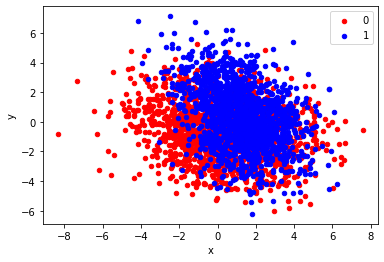

In [2]:
from sklearn.datasets import make_moons,make_classification
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
# X, y = make_moons(n_samples=3000, noise=0.15)
X, y = make_classification(n_samples=3000,n_features=20, n_redundant=2, n_informative=10,
                           random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += .5 * rng.uniform(size=X.shape)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [3]:
from sklearn.model_selection import train_test_split
import copy

#we now want labeled set and "unlabeled" pool.
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.8, random_state=42)

X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X_train, y_train, test_size=0.15, random_state=42) # 0.25 x 0.8 = 0.2

In [4]:
for i in (y_unlabeled, y_labeled, y_test): #few labeled, some unlabeled
    print(i.shape)

(510,)
(90,)
(2400,)


In [5]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_labeled, y_labeled)
clf.score(X_test,y_test)

0.7770833333333333

In [6]:
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors


def initialize_opposite_pair(X_labeled:np.ndarray,y_labeled:np.ndarray,verbose=False):
    '''
    Initialize an opposite pair based on binary class membership and nearest centroids.
    '''
    clf = NearestCentroid() #to get initial centroids for opposite pairing.
    clf.fit(X_labeled, y_labeled)
    opposite_pair = dict(zip(clf.classes_,clf.centroids_))
    if verbose:
        print(f'Initial opposite pair found as:\n{opposite_pair}')
    return opposite_pair

def ask_oracle(x_q,possible_labels,label_type:str='int'):
    '''
    Ask an oracle for a suitable label to x_q.
    '''
    y_q=None
    while not y_q:
      # Ask the user for a label.
        oracle_label = input(f"The possible labels for this instance should be from \
                            \n {possible_labels}.\n\ \
                            Please provide a suitable label for {x_q}: ")
    if label_type=='int':
        return int(y_q)
    elif label_type=='float':
        return float(y_q)
    else:
        return y_q


In [7]:
def find_pair(X_labeled:np.ndarray,y_labeled:np.ndarray,X_unlabeled:np.ndarray,y_unlabeled=None,b:int = 64, opposite_pair=None, y_unlabeled_provided=True):
    '''
    Find a new opposite pair with 𝑏 bits of precision (unless not enough instances remain) via binary search about the hyperplane.
    If opposite_pair is not provided, initialize it with centroids of labeled set.
    '''

    if opposite_pair==None:
        opposite_pair=initialize_opposite_pair(X_labeled,y_labeled,verbose=False)
        # {0:x_pos,1:x_neg}
        # "positive" and "negative" just refer to first and second label

    while b and X_unlabeled.shape[0]>0:

        #synthesize a new instance
        x_pos,x_neg=tuple(opposite_pair.values())
        x_s = (x_pos+x_neg)/2

        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(X_unlabeled) #want to find nearest neighbor of x_s within unlabeled pool
        _, idx = nn.kneighbors(x_s.reshape(1,-1))
        idx=idx.squeeze()

        x_q = X_unlabeled[idx]
        #query x_q for y_q
        if not y_unlabeled_provided:
            y_q = ask_oracle(x_q,possible_labels=np.unique(y_labeled),label_type='int')
        else:
            y_q=y_unlabeled[idx]
            y_unlabeled = np.delete(y_unlabeled,idx,0) #delete off the used value if matrix is present

        X_labeled = np.vstack((X_labeled,x_q))
        try:
            y_labeled = np.vstack((y_labeled,y_q))
        except:
            y_labeled = np.append(y_labeled.flatten(),y_q)
        # finally:
        #     pass
        X_unlabeled= np.delete(X_unlabeled,idx,0)

        # if xq is positive (y_q is 0) then x+ ← xq. else (y_q is 1), x− ← xq
        # therefore, we can set the following
        opposite_pair[y_q]=x_q
        
        b-=1


    return opposite_pair,X_labeled,X_unlabeled, y_labeled, y_unlabeled

In [8]:
def get_perp_query(opposite_pair, magnitude:float = 1.0) -> np.ndarray :
    '''
    Synthesize the midperpendicular query given the opposite pair.
    
    Per the paper:
    "This new synthesis can be obtained by adding an orthogonal vector to the mid-point. We can find the vector by orthogonalizing a random vector using Gram-Schmit process and normalize its mag-nitude to λ."
    '''

    x_pos,x_neg = tuple(opposite_pair.values())
    x_naught = x_pos - x_neg
    x_r = np.random.rand(*x_naught.shape)

    # Use Gram-Schmit process to make x_r orthogonal to x_o
    x_r = x_r - np.dot(x_r,x_naught) / np.dot(x_naught,x_naught)*x_naught
    # set magnitude
    x_r = magnitude/np.linalg.norm(x_r)*x_r

    x_s = x_r + (x_pos+x_neg)/2

    return x_s


In [9]:
from tqdm.notebook import tqdm, trange

def active_learning(learner, X_labeled:np.ndarray,y_labeled:np.ndarray,X_unlabeled:np.ndarray,y_unlabeled: np.ndarray,y_unlabeled_provided=True, n_queries:int = 200, b:int = 64, magnitude:float = 1.0,X_test=None,y_test=None):
    '''
    Perform an active learning loop.
    '''

    #get centroids
    initial_opposite_pair = initialize_opposite_pair(X_labeled,y_labeled,verbose=False)

    opposite_pair,X_labeled,X_unlabeled, y_labeled, y_unlabeled = find_pair(
        X_labeled=X_labeled,y_labeled=y_labeled,X_unlabeled=X_unlabeled,y_unlabeled=y_unlabeled,          b=b, opposite_pair=initial_opposite_pair, y_unlabeled_provided=True)

    history=[]
    n = n_queries - b
    for _ in trange(n):
        if X_unlabeled.shape[0]==0: break

        # iterate for (number of desired points to use from pool) minus (bits used in initial search).
        x_s = get_perp_query(opposite_pair,magnitude)

        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(X_unlabeled) #want to find nearest neighbor of x_s within unlabeled pool
        _, idx = nn.kneighbors(x_s.reshape(1,-1))
        idx=idx.squeeze()

        x_q = X_unlabeled[idx]
        #query x_q for y_q
        if not y_unlabeled_provided:
            y_q = ask_oracle(x_q,possible_labels=np.unique(y_labeled),label_type='int')
        else:
            y_q=y_unlabeled[idx]
            y_unlabeled = np.delete(y_unlabeled,idx,0) #delete off the used value if matrix is present

        X_labeled = np.vstack((X_labeled,x_q))
        try: y_labeled = np.vstack((y_labeled,y_q))
        except: y_labeled = np.append(y_labeled.flatten(),y_q)
        # finally: pass
        X_unlabeled= np.delete(X_unlabeled,idx,0)
        
        learner.fit(X_labeled,y_labeled)
        history.append(learner.score(X_test,y_test))
        
    return learner,history



  0%|          | 0/336 [00:00<?, ?it/s]

<AxesSubplot:>

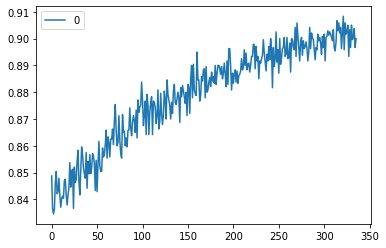

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# clf=LogisticRegression()
clf=RandomForestClassifier()
learner,history=active_learning(clf, X_labeled,y_labeled,X_unlabeled,y_unlabeled, n_queries=400, b=64,X_test=X_test,y_test=y_test)

pd.DataFrame(history).plot()


  0%|          | 0/346 [00:00<?, ?it/s]

<AxesSubplot:>

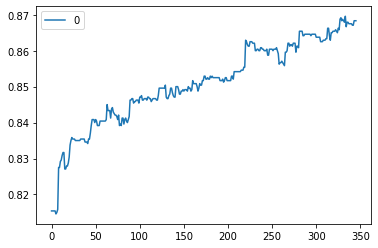

In [11]:
X, y = make_classification(n_samples=3000,n_features=20, n_redundant=2, n_informative=10,
                           random_state=1, n_clusters_per_class=2)
rng = np.random.RandomState(2)
X += .5 * rng.uniform(size=X.shape)

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.8, random_state=42)
X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X_train, y_train, test_size=0.15, random_state=42) # 0.25 x 0.8 = 0.2

from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
learner,history=active_learning(clf, X_labeled,y_labeled,X_unlabeled,y_unlabeled, n_queries=410, b=64,X_test=X_test,y_test=y_test)

pd.DataFrame(history).plot()
